In [16]:
import pandas as pd
import numpy as np
import glob
import graspologic as gp
import seaborn as sns
import os
import re
import matplotlib.pyplot as plt
import sys
sys.path.append("../simulations/")
from sims import *
from graphbook_code import cmaps
import dask
from dask.distributed import Client, progress
import dask.dataframe as ddf
import logging
import warnings
warnings.filterwarnings("ignore")
import contextlib

In [17]:
def read_connectome(path):
    gr = pd.read_excel(path)
    gr_ar = np.array(gr.drop(gr.columns[0], axis=1))
    np.fill_diagonal(gr_ar, 0)
    gr_gp = gp.utils.pass_to_ranks(gr_ar)
    return gr_gp

conn_paths = glob.glob("Connectomes/*.xlsx")

In [18]:
%%script false --no-raise-error

graphs = np.stack([read_connectome(conn) for conn in conn_paths], axis=0)
np.save("Connectomes/graphs.npy", graphs)

In [19]:
def grab_covariates(conn_paths, covar_path, filter_genotypes=["APOE44HN", "APOE33HN", "HN", "APOE22HN"]):
    basenames = [os.path.basename(path).split("_")[0] for path in conn_paths]

    covars = pd.read_csv(covar_path)
    covars["DWI"] = [re.split("_|-", str(name))[0] for name in covars["DWI"]]
    covar_df = []
    for i, basename in enumerate(basenames):
        pd_row = covars[covars["DWI"] == basename]
        if pd_row.shape[0] > 1:
            print("Error: {:s}".format(basename))
        elif pd_row.shape[0] == 0:
            print("No row: {:s}".format(basename))
            covar_conn = {"Id": basename, "Diet": np.nan, "Age": np.nan, "Sex": np.nan, "Genotype": np.nan}
        else:
            covar_conn = {"Mouse": basename, "Id": i, "Diet": pd_row["Treatment"].item(), "Age": float(pd_row["Age_Years"].item()),
                          "Sex": pd_row["Sex_other"].item().strip(), "Genotype" : pd_row["Geno"].item()}
        covar_df.append(covar_conn)

    covar_df = pd.DataFrame(covar_df)
    scrubbed_df = covar_df[~covar_df["Genotype"].isin(["APOE44HN", "APOE33HN", "HN", "APOE22HN"])]
    scrubbed_df = scrubbed_df.dropna()
    return scrubbed_df

In [20]:
graphs = np.load("Connectomes/graphs.npy")
scrubbed_covariates = grab_covariates(conn_paths, "./phenotypic.csv")
graphs_without_nas = graphs[scrubbed_covariates["Id"].tolist(),:,:]

node_labels = pd.read_csv("./node_label_dictionary.csv")
node_labels["Hem"] = node_labels["Hemisphere"].map({"Left": "L", "Right": "R"})
node_labels["L1"] = node_labels["Level_1"].map({"1_forebrain": "F", "2_midbrain": "M",
                                                   "3_hindbrain": "H", "4_white_matter_tracts": "W",
                                                   "5_ventricular_system": "V"})
node_labels["Label"] = node_labels["Hem"] + node_labels["Level_4"]
node_labels["Label"]

No row: N58216
No row: N58232
No row: N58225
No row: N58612
No row: N58636
No row: N58610
No row: N58634
No row: N58214
No row: N58230
No row: N58217
No row: N58224
No row: N58654
No row: N58611
No row: N58226
No row: N58635
No row: N58649
No row: N58215
No row: N58231
No row: N58633
No row: N58228
No row: N58650
No row: N58219
No row: N57504
No row: N58222
No row: N58229
No row: N58651
No row: N58221
No row: N58218
No row: N58400
No row: N58223
No row: N58653


0                     L2_cingulate_cortex
1                     L2_cingulate_cortex
2                     L2_cingulate_cortex
3                     L2_cingulate_cortex
4                     L2_cingulate_cortex
                      ...                
327         Raxial_hindbrain_white_matter
328                       R5_hypothalamus
329                          R17_thalamus
330                       R5_hypothalamus
331    R8_pallial_and_subpallial_amygdala
Name: Label, Length: 332, dtype: object

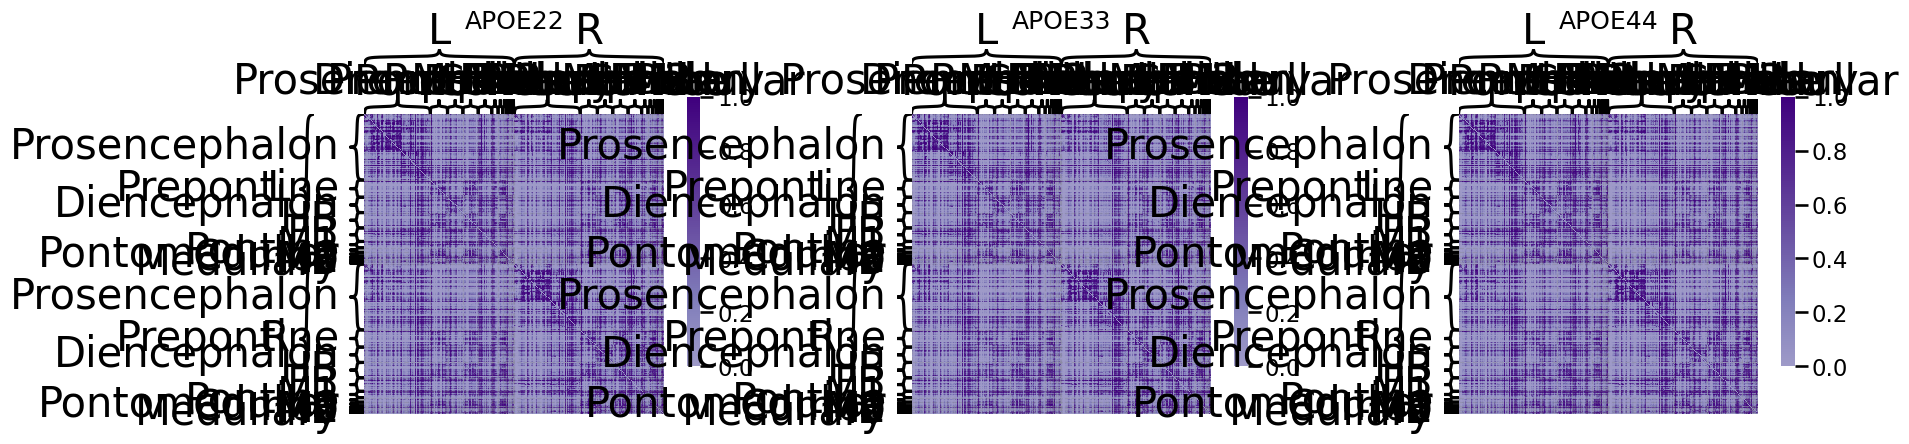

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
genotypes = ["APOE22", "APOE33", "APOE44"]
for (i, genotype) in enumerate(genotypes):
    relevant_idx = scrubbed_covariates[scrubbed_covariates["Genotype"] == genotype]["Id"].tolist()
    cond_gr = graphs[relevant_idx,:,:].mean(axis=0)
    gp.plot.heatmap(cond_gr, title=genotype, outer_hier_labels=node_labels["Hem"], inner_hier_labels=node_labels["Level_2_abbrev"],
                    ax=axs[i], vmin=0, vmax=1, cmap=cmaps["sequential"])

In [22]:
results = []

scrubbed_covariates["Genotype"] = pd.Categorical(scrubbed_covariates["Genotype"])
scrubbed_covariates["Sex"] = pd.Categorical(scrubbed_covariates["Sex"])
scrubbed_covariates["Diet"] = pd.Categorical(scrubbed_covariates["Diet"])
Xs = scrubbed_covariates.loc[:, ["Sex", "Diet", "Age"]]
# OHE relevant columns
ohe_sex = pd.get_dummies(Xs["Sex"])
ohe_diet = pd.get_dummies(Xs["Diet"])
Xs = Xs.drop("Diet", axis=1)
Xs = Xs.drop("Sex", axis=1)
Xs = Xs.join(ohe_sex)
Xs = Xs.join(ohe_diet)
# normalize the data to 0 mean, 1 std
Xs_normalized = (Xs - Xs.mean(axis=0))/Xs.std(axis=0)
Ts = scrubbed_covariates["Genotype"].cat.codes.to_numpy()

In [23]:
balanced_ids = causal_prep(Xs_normalized.to_numpy(), Ts)
Xs_causal = Xs_normalized[balanced_ids]
Ts_causal = Ts[balanced_ids]
graphs_causal = graphs_without_nas[balanced_ids,:,:]

         Current function value: 0.866235
         Iterations: 35


In [25]:
from itertools import combinations
ncores = 10
nrep = 10000
nodelabs = node_labels["Label"]


def run_comb(row):
    if row["index"] % 10 == 0:
        print("Combination: {:d} of {:d}".format(i, num_combs))
    pval, stat = cond_dcorr(graphs_causal[:,nodelabs == row["Community k"],:][:,:,nodelabs == row["Community l"]].reshape(graphs_causal.shape[0],-1),
                            Ts_causal, Xs_causal, nrep=10000)
    tuple([row["Community k"], row["Community l"], pval, stat])


exps = []

un_labs = np.unique(node_labels["Label"])

for k in range(0, len(un_labs)):
    for l in range(k, len(un_labs)):
        exps.append([un_labs[k], un_labs[l]])

realdat_exps = pd.DataFrame(exps, columns=["Community k", "Community l"])
realdat_exps["index"] = range(0, len(realdat_exps))
print(realdat_exps.head())
client = Client(threads_per_worker=1, n_workers=ncores, silence_logs=logging.ERROR)
print(client)

             Community k                Community l  index
0  L10_subpallial_septum      L10_subpallial_septum      0
1  L10_subpallial_septum  L11_paraseptal_subpallium      1
2  L10_subpallial_septum        L12_lateral_pallium      2
3  L10_subpallial_septum        L12_parietal_cortex      3
4  L10_subpallial_septum       L13_occipital_cortex      4
<Client: 'tcp://127.0.0.1:64700' processes=10 threads=10, memory=32.00 GiB>


In [24]:
realdat_exps = ddf.from_pandas(sim_exps, npartitions=ncores)
realdat_results = realdat_exps.apply(lambda x: run_comb(x), axis=1, result_type='expand',
                             meta={0: str, 1: str, 2: float, 3: float})
realdat_results = realdat_results.compute(scheduler="multiprocessing")

<Client: 'tcp://127.0.0.1:64561' processes=10 threads=10, memory=32.00 GiB>


In [ ]:
realdat_results = realdat_results.rename(columns={0: "Community k", 1: "Community l", 2: "p-value", 3: "Test Statistic"})

realdat_results["Community k"] = realdat_results["Community k"].astype("category")
realdat_results["Community l"] = realdat_results["Community l"].astype("category")

sim_results.to_pickle('./data/mouse_results.pkl')

In [ ]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import rankdata

res_dat["adjusted p-value"] = multipletests(res_dat["p-value"], method="fdr_bh")[1]
alpha = 0.05
res_dat["Test Outcome"] = (res_dat["adjusted p-value"] < alpha).astype(int)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
res_dat["log(adjusted p-value)"] = np.log(res_dat["adjusted p-value"])
res_df = res_dat.pivot("Community l", "Community k", "log(adjusted p-value)")
sns.heatmap(res_df, ax=ax, cmap="Purples_r", vmax=0)
ax.set_title("Regions with differences by mouse genotype")

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4))

res_df = res_dat.pivot("Community l", "Community k", "Test Outcome")
sns.heatmap(res_df, ax=ax, cmap=cmaps["sequential"])
ax.set_title("Regions with differences by mouse genotype")

In [ ]:
graphs_without_nas.shape